
<img src="img/logo_wiwi.png" width="25%" align="left">

<img src="img/decision_analytics_logo.png" width="17%" align="right">



<br><br><br><br><br><br><br><br>



# Algorithmen und Datenstrukturen(A+D)-Projekt 

**Sommersemester 2023**


# 4. Von Greedy zur Baumsuche
<br>

<br>
<br>

**J-Prof. Dr. Michael Römer, Till Porrmann**

Juniorprofessur für Decision Analytics  | Universität Bielefeld

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
import networkx as nx
import keyboard
from IPython.display import SVG, display, clear_output

from heapq import nsmallest

# Organisatorisches

## Termine Zwischen- und Abschlusspräsentation

**Zwischenpräsentation**: Terminvorschlag_ Montag,  22. Mai 2023 von 9-12 Uhr

**Frage:**
- wem würde **kein Zeitslot** passen?

## Zur Zwischenpräsentation


- **Dauer:** Je Gruppe: 10 Minuten + 5 Minuten Diskussion

**Inhalte:**
- Kurze Beschreibung des Optimierungsproblems
- Sachliche Ergebnisse, z.B.:
    - Vorstellung des / der bisher entwickelten Algorithmen
    - Erste Ergebnisse - Qualität und Laufzeit
- Erfahrungen aus der Projektarbeit, z.B.
  - Arbeitsweise
  - Herausforderungen / Erfolge

- Ziele / geplante weitere Arbeiten bis zum Projektende



## Was machen wir heute?

- wir betrachten Greedy aus der Perspektive von Baumsuche
- wir betrachten Breitensuche und Beam Search als Varianten der Baumsuche

# Wiederholung: Nearest Neighbor als Greedy-Verfahren für das TSP

## Ein Greedy-Ansatz für das TSP / SHPP: Nearest-Neighbor

<img src="./img/32.png" width="20%" align="right">


Eine einfache und sehr bekannte Heuristik für das SHPP (und das TSP) nennt sich **nearest neighbor**:
- man startet bei einem Knoten und
- wählt in jedem Schritt immer den Knoten aus, der dem aktuellen am nächsten ist:

Beispiel rechts: wir starten in Marin und suchen immer den nächsten Nachbarn

## TSP in Python: Distanzmatrix

- die einzige Information, die wir für die Darstellung des TSP brauchen, ist eine **Distanz-Matrix**
- in dieser (symmetrischen) Matrix steht in jedem Element $[i,j]$ die Distanz zwischen den Knoten (Orten) $i$ und $j$
- als Beispiel betrachten wir folgende Matrix:


In [2]:
distance_matrix = np.array([
    [0,  5, 4, 10],
    [5,  0, 8,  5],
    [4,  8, 0,  3],
    [10, 5, 3,  0]
])

distance_matrix_small = distance_matrix

## Eine Routine zum Evaluieren einer Lösung

- immer wenn man nicht-triviale Algorithmen für Optimierungsprobleme entwickelt, sollte man einen "Solution-Checker" schreiben / nutzen

><div class="alert alert-block alert-info">
<b>Was ist im Fall des TSP zu prüfen?</b></div>  


**Im Fall des TSP gilt es:**
- zu prüfen, ob
  - die Lösung die Richtige Anzahl an Knoten enthält
  - dass es sich bei der Lösung tatsächlich um eine Permutation der Indizes handelt (kein Index kommt zweimal vor)
- die Distanz der Tour zu berechnen

In [3]:
def evaluate_tsp_solution(distance_matrix, tour):
    n = len(distance_matrix)
    if len(tour) != n:
        print ("Wrong number of nodes")
        return -1
     # Menge der Lösungsindizes muss = der Menge der Indizes von 0 bis n-1 sein
    if set(tour) != set(range(n)):
        print ("Not a proper tour!")
        return  -1
    
    total_distance = 0
    for i in range(n):
        if i < n-1:
            total_distance += distance_matrix[tour[i],tour[i+1]]
        else:
            total_distance += distance_matrix[tour[i],tour[0]]   
            
    return total_distance    

...probieren wir es aus:

In [4]:
tour = [0,1,2,3]
evaluate_tsp_solution(distance_matrix, tour)

26

## Erweiterung: Evaluation zum Überprüfen einer gegebenen Distanz

- oftmals ist es nützlich, in einer Funktion direkt die vom Algorithmus berechnete Distanz zu prüfen
- folgende Funktion macht eine entsprechende Ergebnisausgabe:


In [5]:
def print_obj_and_eval_tsp_solution(distance_matrix, tour, distance):
    
    eval_distance = evaluate_tsp_solution(distance_matrix, tour)
    
    if distance == eval_distance:
        print ("Solution feasible, distance is: ", distance)
    elif eval_distance < 0:
        print("Solution infeasible")
    else: 
        print("Solution feasible, wrong distance: ", distance, " evaluation gave ", eval_distance)

...probien wir es aus:

In [6]:
distance = 17
print_obj_and_eval_tsp_solution(distance_matrix, tour, distance)

Solution feasible, wrong distance:  17  evaluation gave  26


## Das Python-Paket `python-tsp` testen

- TSP-Instanzen einlesen

In [7]:
from python_tsp.distances import tsplib_distance_matrix

# Lokale Installation
instances_path = "./../instances/tsp/" 

#Im Fall von Colab (oder lokal im selben Ordner wir Notebook) nach drag&drop:
#instances_path = "./" 

instance_name = "a280.tsp" # optimale Lösung 2579 (lt. http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/STSP.html)
#instance_name = "brazil58.tsp" # optimale Lösung 25395 (lt. http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/STSP.html)
instance_name = "berlin52.tsp" # optimale Lösung 7542 (lt. http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/STSP.html)
tsplib_file = instances_path+instance_name 


distance_matrix = tsplib_distance_matrix(tsplib_file)


 - heuristische TSP-Algorithmen:

In [8]:
from python_tsp.heuristics import solve_tsp_local_search, solve_tsp_simulated_annealing

In [9]:
%%time
tour, distance = solve_tsp_simulated_annealing(distance_matrix)
distance

CPU times: total: 1.62 s
Wall time: 1.62 s


7956

- exakte TSP-Algorithmen basierend auf Enumeration und dynamischer Programmierung
  - (vorsicht: dauert wahrscheinlich lange mit Instanzen > 10 Items)
  

In [10]:
from python_tsp.exact import solve_tsp_dynamic_programming

#tour, distance = solve_tsp_dynamic_programming(distance_matrix_21)

#distance

## Nearest Neighbor als Greedy-Verfahren für das TSP: Hilfsfunktion

- hier eine etwas andere Implementierung als zuvor:
  - zuvor hatten wir eine Hilfsfunktion: `select_nearest_neighbor`, die den nächsten Knoten ausgewählt hat
  - nun schreiben wir eine Funktion, die uns für jeden zulässigen Nachbarn (der noch nicht in der Tour ist) ein `tuple` `(distance, tour)` gibt, mit der Distanz und der gesamten Kandidaten-Tour 
  - beachte: Wir schließen die "Rückfahrt" ein!

In [11]:
@njit
def get_dist_feasible_candidate_tours(tour, total_distance, distance_matrix):
    
    dist_candidate_tour = []
    for neighbor, distance in enumerate(distance_matrix[tour[-1]]):
        if neighbor in tour:
            continue
        
        candidate_tour = tour + [neighbor]
        
        if len(candidate_tour) == len(distance_matrix):
            distance += distance_matrix[neighbor, tour[0]]
        
        total_distance_candidate_tour = total_distance + distance
        dist_candidate_tour.append((total_distance_candidate_tour, candidate_tour))
        
        
    return dist_candidate_tour


In [12]:
get_dist_feasible_candidate_tours([1], 0, distance_matrix_small)

C:\Users\mroemer\Miniconda3\envs\audprojekt2022\lib\site-packages\numba\core\ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'tour' of function 'get_dist_feasible_candidate_tours'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\..\AppData\Local\Temp\ipykernel_12540\1558771343.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\Users\mroemer\Miniconda3\envs\audprojekt2022\lib\site-packages\numba\core\ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'lst' of function 'in_seq.<locals>.seq_contains_impl'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#depr

[(5, [1, 0]), (8, [1, 2]), (5, [1, 3])]

## Nearest Neighbor als Greedy-Verfahren für das TSP: Hauptfunktion

- die Hauptfunktion `tsp_greedy` sieht dann auch leicht anders aus:
  - beachte: der erste Parameter ist eine Tour!
  - und: durch die Verwendung des tupels `(distance, tour)` für jeden Nachbarn können wir einfach das Minimum aus der Liste der Tupel suchen (denn das erste Element wird zum Vergleich zuerst herangezogen)

In [13]:
@njit
def tsp_greedy(tour, distance_matrix):
        
    total_distance = 0
    
    #solange die sequenz noch nicht alle Knoten umfasst
    while len(tour) < len(distance_matrix):    
        
        #bestimme alle zulässigen Nachbarn und deren Entfernungen
        dist_neighbors = get_dist_feasible_neighbors(tour, distance_matrix)   
        
        # bestimme das minimale Tupel (der erste Wert des Tupels, d.h. die Distance, wird automatisch genutzt)
        distance, next_node = min(dist_neighbors)
        
        tour.append(next_node)
        total_distance += distance     
        
    total_distance += distance_matrix[tour[len(tour)-1],tour[0]]
    return tour, total_distance

In [14]:
@njit
def tsp_greedy(tour, distance_matrix):
        
    total_distance = 0
    
    #solange die sequenz noch nicht alle Knoten umfasst
    while len(tour) < len(distance_matrix):    
        
        #bestimme alle zulässigen Nachbarn und deren Entfernungen
        dist_candidate_tours = get_dist_feasible_candidate_tours(tour, total_distance, distance_matrix)   
        
        # bestimme das minimale Tupel (der erste Wert des Tupels, d.h. die Distance, wird automatisch genutzt)
        distance_best_candidate_tour, best_candidate_tour = min(dist_candidate_tours)
        
        tour = best_candidate_tour
        total_distance = distance_best_candidate_tour    
        

    return tour, total_distance

In [15]:
tour, distance = tsp_greedy([0], distance_matrix)
distance

C:\Users\mroemer\AppData\Local\Temp\ipykernel_12540\1561615480.py:10: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'tour' of function 'get_dist_feasible_candidate_tours'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\..\AppData\Local\Temp\ipykernel_12540\1558771343.py", line 1:
<source missing, REPL/exec in use?>

  dist_candidate_tours = get_dist_feasible_candidate_tours(tour, total_distance, distance_matrix)
C:\Users\mroemer\AppData\Local\Temp\ipykernel_12540\1561615480.py:13: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'a' of function 'list_lt.<locals>.list_lt_impl'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflectio

8980

## Abstraktion: Zustands(raum)modellierung / State Space Representation

Ein Greedy-Verfahren konstruiert Schritt für Schritt eine Lösung (es ist ein Konstruktionsverfahren)

Für jeden Schritt müssen wir folgende Fragen beantworten:
1. Welche Entscheidungen / Handlungen / Aktionen sind möglich?
2. Welche der möglichen Entscheidungen sollte gewählt werden?

Zur Beantwortung von Frage 1 brauchen wir:
- eine Beschreibung des aktuellen **Zustands**:
  - TSP: die bisherige Tour
  - Rucksackproblem: das bisher eingepackte Gewicht 
- die "Regeln" / Restriktionen, die beschreiben, **welche Handlungen in einem Zustand zulässig sind**
  - TSP: kein erneuter Besuch einer bereits besuchten Stadt
  - Rucksackproblem: Gegenstand einpacken geht nur, wenn das Gesamtgewicht nicht überschritten wird

Zur Beantwortung von Frage 2 brauchen wir ein Auswahl-Kriterium
- z.B. der Wert der neuen Teillösung:
  - TSP: Distanz der (Teil-)Tour nach Hinzunahme des Nacharn
  - Rucksackproblem: Gesamtwert der Lösung nach Hinzunahme eines Elements

## Die Suche im Lösungsraum kann als Graph dargestellt werden

- man nennt diesen Graph den Suchgraph oder auch **Suchbaum**
- in diesem Graph entsprechen 
  - die Knoten den **Zuständen** (siehe oben)
  - die Kanten den **Entscheidungen**
  


Wir können daher **Suchverfahren in Graphen** anwenden, um eine optimale Lösung zu finden.
- wir schauen uns das gleich einmal für den Greedy-Fall an

## Beachte: Es folgen Funktionen zur Visualisierung
- wir möchten manche unserer Algorithmen visualisieren
- dazu nutzen wir einige Hilfsfunktionen sowie
- angepasste Implementierungen unserer Algorithmen

**Wichtig:** Die Anpassungen brauchen wir nicht für die Algorithmen selbst!

In [16]:
    
def add_to_search_graph(g, prev_state, state, decision, distance_decision, distance_state):
    clear_output()
    g.add_edge(prev_state,state, label= " add:" + str(decision) + " d:" + str(distance_decision))
    g.nodes()[state]["xlabel"]= distance_state
    svg = nx.nx_agraph.to_agraph(g).draw(prog='dot',format='svg')
    display(SVG(svg))


## Eine visualisierte Version des Greedy-Verfahrens für das TSP

In [17]:
def tsp_greedy_visualized(tour, distance_matrix):
    total_distance = 0
    g = nx.MultiDiGraph()
    
    #solange die sequenz noch nicht alle Knoten umfasst
    while len(tour) < len(distance_matrix):    
        
        #bestimme alle zulässigen Kandidatentouren und deren Entfernungen
        dist_candidate_tours = get_dist_feasible_candidate_tours(tour, total_distance, distance_matrix)   
        
        # bestimme das minimale Tupel (der erste Wert des Tupels, d.h. die Distance, wird automatisch genutzt)
        distance_best_candidate_tour, best_candidate_tour = min(dist_candidate_tours)
        
        next_node = best_candidate_tour[-1]
        
        next_node_distance = distance_best_candidate_tour - total_distance
        
        add_to_search_graph(g, tuple(tour), tuple(best_candidate_tour), next_node, next_node_distance, total_distance)
        
        tour = best_candidate_tour
        total_distance = distance_best_candidate_tour   
        keyboard.read_key()
        
    return tour, total_distance    


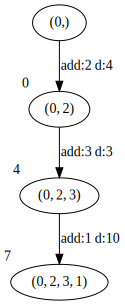

17


In [18]:

tour, distance = tsp_greedy_visualized([0], distance_matrix_small)
print (distance)

## Durchlaufen des Suchbaums: Breitensuche

- Greedy betrachtet pro Stufe / Level / Ebene des Suchbaums nur einen einzigen Zustandsknoten
- Wenn wir alle Knoten betrachen, haben wir eine **Breitensuche** (siehe Vorlesung)

In [19]:
def tsp_breadth_first_search_visualized(tour, distance_matrix):
        
    total_distance = 0
    
    ## für die Visualisierung
    g = nx.MultiDiGraph()
    
    # alle Zustandsknoten als Distanz-Tour-Tupel in der aktuellen Stufe / Ebene 
    dist_tours_current_stage = [(0, tour.copy())] 
    
    for stage in range(0,len(distance_matrix)-1):
        
        dist_tours_next_stage = []
        
        for tour_dist, current_tour in dist_tours_current_stage:
            
            old_tour_tuple = tuple(current_tour)
            
            #bestimme alle zulässigen Tourerweiterungen und deren Entfernungen
            dist_candidate_tours = get_dist_feasible_candidate_tours(current_tour, tour_dist, distance_matrix)   
        
            for candidate_tour_dist, candidate_tour in dist_candidate_tours:
                         
                next_node = candidate_tour[-1]
        
                next_node_distance = candidate_tour_dist - tour_dist
            
                add_to_search_graph(g, old_tour_tuple, tuple(candidate_tour), next_node, next_node_distance, candidate_tour_dist)
                
                keyboard.read_key()

                dist_tours_next_stage.append( (candidate_tour_dist, candidate_tour) )
                
        dist_tours_current_stage = dist_tours_next_stage.copy()

    best_distance, best_tour  = min(dist_tours_current_stage)
    return best_tour, best_distance

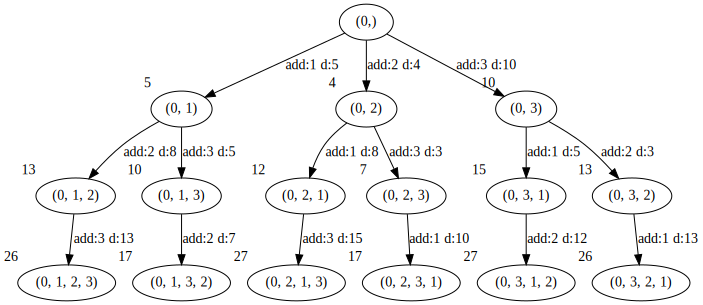

In [20]:
tour, distance = tsp_breadth_first_search_visualized([0], distance_matrix_small)

In [21]:
print(distance)

17


# Beam Search: Einschränkung der Breitensuche

- Idee: ein Kompromiss zwischen Greedy und Breitensuche
- übernimm auf jeder Stufe nur eine bestimmte Anzahl (beam-width) von Zustandsknoten
  - Auswahl z.B. auf Basis von Distanz der Tour
- hier einfache Implementierung mit der Funktion `nsmallest` aus dem Paket `heapq`

In [22]:
from heapq import nsmallest
def tsp_beam_search_visualized(tour, distance_matrix, beam_width):
        
    total_distance = 0
    
    ## für die Visualisierung
    g = nx.MultiDiGraph()
    
    # alle Zustandsknoten als Distanz-Tour-Tupel in der aktuellen Stufe / Ebene 
    dist_tours_current_stage = [(0, tour.copy())] 
    
    for stage in range(0,len(distance_matrix)-1):
        
        dist_tours_next_stage = []
        
        for tour_dist, current_tour in dist_tours_current_stage:
            
            old_tour_tuple = tuple(current_tour)
            
            #bestimme alle zulässigen Tourerweiterungen und deren Entfernungen
            dist_candidate_tours = get_dist_feasible_candidate_tours(current_tour, tour_dist, distance_matrix)     
            
        
            for candidate_tour_dist, candidate_tour in dist_candidate_tours:
                         
                next_node = candidate_tour[-1]
        
                next_node_distance = candidate_tour_dist - tour_dist
            
                add_to_search_graph(g, old_tour_tuple, tuple(candidate_tour), next_node, next_node_distance, candidate_tour_dist)
                
                keyboard.read_key()

                dist_tours_next_stage.append( (candidate_tour_dist, candidate_tour) )
                
        dist_tours_current_stage = nsmallest(beam_width, dist_tours_next_stage)

    
    best_distance, best_tour  = min(dist_tours_current_stage)
    
    return best_tour, best_distance

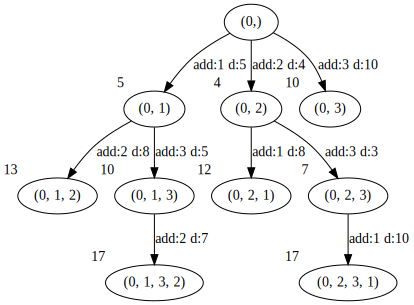

In [23]:
tour, distance = tsp_beam_search_visualized([0], distance_matrix_small, 2)

In [24]:
print(distance)

17


## Beam Search ohne Visualisierung

- zum Testen größerer Instanzen hier Code ohne Visualisierung:

In [25]:

def tsp_beam_search(tour, distance_matrix, beam_width):
        
    total_distance = 0
    
    
    # alle Zustandsknoten als Distanz-Tour-Tupel in der aktuellen Stufe / Ebene 
    dist_tours_current_stage = [(0, tour.copy())] 
    
    for stage in range(0,len(distance_matrix)-1):
        
        dist_tours_next_stage = []
        
        for tour_dist, current_tour in dist_tours_current_stage:
                  
            #bestimme alle zulässigen Tourerweiterungen und deren Entfernungen
            dist_candidate_tours = get_dist_feasible_candidate_tours(current_tour, tour_dist, distance_matrix)     
            
        
            for candidate_tour_dist, candidate_tour in dist_candidate_tours:                         

                dist_tours_next_stage.append( (candidate_tour_dist, candidate_tour) )
                
        dist_tours_current_stage = nsmallest(beam_width, dist_tours_next_stage)

    
    best_distance, best_tour  = min(dist_tours_current_stage)
    return best_tour, best_distance

..probieren wir es aus:

In [26]:
tour, distance = tsp_beam_search([0], distance_matrix, 1)

print (distance)

8980


## Zwischenfazit: Baumsuche

- Greedy kann als Baumsuch-Verfahren interpretiert werden
- Breitensuche ist eine enumerative Baumsuche
- Beam Search limitiert die Anzahl der untersuchten Zustände

#### Beim nächsten Mal
- interpretieren wir **rollout** als **heuristische Funktion** in einem **informierten** Suchverfahren
- schauen wir, ob wir mit diesem Ansatz Beam Search verbessern können